## Clustering Using Pyspark

For this project we will attempt to use KMeans Clustering to cluster Mall customer dataset.
We will make segmentation of those customers.

We will try 2 scenario to make cluster:
1. Include OneHotEncoder process 
2. Exclude OneHotEncoder process

### Pyspark Initializasing

In [1]:
!pip install findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 47 kB/s 
     |████████████████████████████████| 199 kB 42.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=1c8672c22fbdcaabf015a6408e4bd278728356d25e3c689a2e51736c02bf1d78
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
# to make pyspark importable as a regular library
import findspark
findspark.init()

import pyspark

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

#initializasing SparkSession for creating Spark DataFrame
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

### Load Libraries

In [3]:
# Data Frame spark profiling 
from pyspark.sql.types import IntegerType, StringType, DoubleType, ShortType, DecimalType
import pyspark.sql.functions as func
from pyspark.sql.functions import isnull
from pyspark.sql.functions import isnan, when, count, col, round
from pyspark.sql.functions import mean
from pyspark.sql.types import Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf


# Pandas DF operation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array

# Modeling + Evaluation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql import functions as F
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from mpl_toolkits.mplot3d import Axes3D


### Load Data to Spark DataFrame

In [4]:
#Initializing File Type
file_type = 'text'
path=r'Mall_Customers.csv'
delimeter=','

In [5]:
def load_data(file_type):
    """input type of file "text" or "parquet" and Return pyspark dataframe"""
    if file_type =="text": # use text as file type input
        df = spark.read.option("header", "true") \
        .option("delimeter",delimeter)\
        .option("inferSchema", "true") \
        .csv(path) 
    else:  
        df= spark.read.parquet("example.parquet") #path file that you want import
    return df

In [6]:
df = load_data(file_type)

In [7]:
help(load_data)

Help on function load_data in module __main__:

load_data(file_type)
    input type of file "text" or "parquet" and Return pyspark dataframe



### Check Data

In [8]:
type(df)

pyspark.sql.dataframe.DataFrame

In [11]:
#show 50 observation in DataFrame
df.show(50)

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
|         6|Female| 22|                17|                    76|
|         7|Female| 35|                18|                     6|
|         8|Female| 23|                18|                    94|
|         9|  Male| 64|                19|                     3|
|        10|Female| 30|                19|                    72|
|        11|  Male| 67|                19|                    14|
|        12|Female| 35|                19|                    99|
|        1

In [12]:
#Print Schema
df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Annual Income (k$): integer (nullable = true)
 |-- Spending Score (1-100): integer (nullable = true)



In [13]:
#rename column name
df=df.withColumnRenamed('CustomerID','Id')
df=df.withColumnRenamed('Annual Income (k$)','AnnIncome')
df=df.withColumnRenamed('Spending Score (1-100)','SpendScore')

In [14]:
len(df.columns), df.columns

(5, ['Id', 'Gender', 'Age', 'AnnIncome', 'SpendScore'])

In [15]:
#Categorical and numerical variable

cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')] #just will select string data type
print("cat_cols:", cat_cols)
num_cols = [item[0] for item in df.dtypes if item[1].startswith('int') | item[1].startswith('double')] #just will select integer or double data type
print("num_cols:", num_cols)

cat_cols: ['Gender']
num_cols: ['Id', 'Age', 'AnnIncome', 'SpendScore']


In [16]:
#Select column 'Id' from num_cols
num_id=num_cols.pop(0)
print("num_id:", num_id)

#save column 'Id' in num_id variable
num_id=[num_id]

#print num_id
print(num_id)

#print num_cols
print(num_cols)

num_id: Id
['Id']
['Age', 'AnnIncome', 'SpendScore']


In [17]:
#count number of observation
df.count()

200

In [18]:
# Check summary statistic of numerical columns
df.select(num_cols).describe().show()

+-------+-----------------+-----------------+------------------+
|summary|              Age|        AnnIncome|        SpendScore|
+-------+-----------------+-----------------+------------------+
|  count|              200|              200|               200|
|   mean|            38.85|            60.56|              50.2|
| stddev|13.96900733155888|26.26472116527124|25.823521668370173|
|    min|               18|               15|                 1|
|    max|               70|              137|                99|
+-------+-----------------+-----------------+------------------+



### Check Missing Value

We are using two metode to check missing values:
1. Using pandas dataframe
2. Using pyspark dataframe

In [19]:
#convert to pandas DataFrame
df_pd=df.toPandas()

In [20]:
#Check Missing value with proportion in Pandas DataFrame

def missing_values_table(df_pd):
    """Input pandas dataframe and Return columns with missing value&percentage and stored as pandas dataframe"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) #count percentage of null in each columns
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #join to left (as column) between mis_val and mis_val_percent and create it as dataframe
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename columns in table, mis_val to Missing Values and mis_val_percent to % of Total Values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)         #sort column % of Total Values descending and round 1 after point(coma)
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns

In [21]:
help(missing_values_table)

Help on function missing_values_table in module __main__:

missing_values_table(df_pd)
    Input pandas dataframe and Return columns with missing value&percentage and stored as pandas dataframe



In [22]:
missing_values_table(df_pd)

Your selected dataframe has 5 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [23]:
#Check Missing Value in Pyspark Dataframe
def count_nulls(df_final):
    """Input pyspark dataframe and return list of columns with missing value and it's total value"""
    null_counts = []          #make an empty list to hold our results
    for col in df.dtypes:     #iterate through the column data types we saw above, e.g. ('C0', 'bigint')
        cname = col[0]        #splits out the column name, e.g. 'C0'    
        ctype = col[1]        #splits out the column type, e.g. 'bigint'
        nulls = df.where( df[cname].isNull() ).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts

In [24]:
help(count_nulls)

Help on function count_nulls in module __main__:

count_nulls(df_final)
    Input pyspark dataframe and return list of columns with missing value and it's total value



In [25]:
null_counts = count_nulls(df)
null_counts

[]

From function count_nulls above we get information all columns that has missing values with it's numbers and save in list "null_counts".

null_counts = [('Genre', 5), ('Annual Income (k$)', 4), ('Spending Score (1-100)', 5)]

From null_counts, we just take information of columns name and save in list "list_cols_miss", like in the script below:

In [26]:
list_cols_miss=[x[0] for x in null_counts]
list_cols_miss

[]

From list_cols_miss create dataframe called "df_miss". The aim is to define categorical and numerical columns which have missing values. 
As the process of handling missing values will be diffrent between  numerical dan categorical variables.

In [27]:
#Create dataframe which just has list_cols_miss
df_miss= df.select(*list_cols_miss)

In [28]:
df_miss.dtypes

[]

After we create "df_miss", we split to categorical and numerical columns which have missing value.
for categorical columns we  called "catcolums_miss" and for numerical columns we called "numcolumns_miss". 
Like in script below:

In [29]:
#Define categorical columns and numerical columns which have missing value.
### for categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("catcolums_miss:", catcolums_miss)

### for numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numcolumns_miss:", numcolumns_miss)

catcolums_miss: []
numcolumns_miss: []


#### Handle Missing Values
So, in this module we will use pyspark dataframe to check missing values.

For categorical columns we use most frequent to fill missing values. Therefore we have to count categories which has max values in each columns by counting and sorting descenting each columns in dataframe with no has missing values. Therefore we drop missing values and save in new dataframe called "df_Nomiss".
For numerical columns we fill missing values with average in it's columns.

In [30]:
#Drop missing value
df_Nomiss=df.na.drop()

In [31]:
df_Nomiss.show(4)

+---+------+---+---------+----------+
| Id|Gender|Age|AnnIncome|SpendScore|
+---+------+---+---------+----------+
|  1|  Male| 19|       15|        39|
|  2|  Male| 21|       15|        81|
|  3|Female| 20|       16|         6|
|  4|Female| 23|       16|        77|
+---+------+---+---------+----------+
only showing top 4 rows



In [32]:
#fill missing value in categorical variable with most frequent
for x in catcolums_miss:
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] #group by based on categories and count each categories and sort descending then take the first value in column
    print(x, mode) #print name of columns and it's most categories 
    df = df.na.fill({x:mode}) #fill missing value in each columns with most frequent

In [33]:
#fill missing value in numerical variable with average
for i in numcolumns_miss:
    meanvalue = df.select(round(mean(i))).collect()[0][0] #calculate average in each numerical column
    print(i, meanvalue) #print name of columns and it's average value
    df=df.na.fill({i:meanvalue}) #fill missing value in each columns with it's average value

In [34]:
#Check Missing value after filling
null_counts = count_nulls(df)
null_counts

[]

Now, output null_counts is null, it's mean no more columns that have missing values.

### EDA
Pyspark dataframe has limitation in visualization. Then to create visualization we have to convert pyspark dataframe to pandas dataframe.

In [35]:
# convert spark dataframe to pandas for visualization
df_pd2=df.toPandas()

#### Categorical Variables

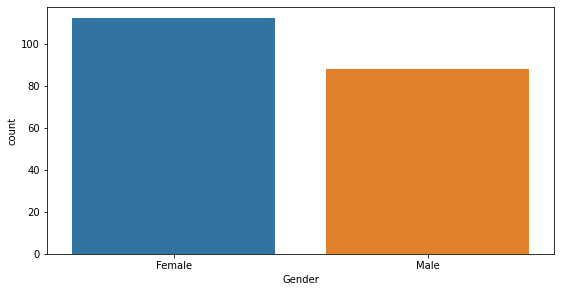

In [38]:
#Barchart for categorical variable
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='Gender', data=df_pd2, order=df_pd['Gender'].value_counts().index)
plt.show()

#### Numerical Variables

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


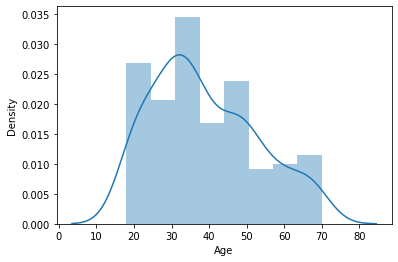

In [39]:
#density plot Age
#plt.figure(figsize=(24,5))
sns.distplot(df_pd2['Age'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


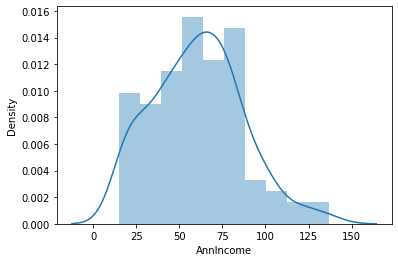

In [40]:
#density plot Annual Income
sns.distplot(df_pd2['AnnIncome'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


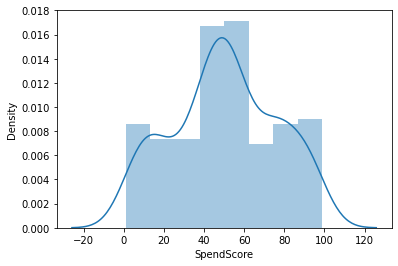

In [41]:
#density plot Spending Score (1-100)
sns.distplot(df_pd2['SpendScore'])
plt.show()

### Check outlier
We will check outlier in all numerical variables, they are: 'Age', 'AnnIncome', 'SpendScore'.

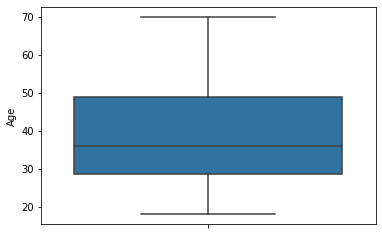

In [42]:
#Check outlier in numerical variable: 'Age'
sns.boxplot(y="Age",data=df_pd2)
plt.show()

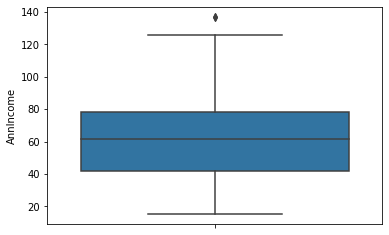

In [43]:
#Check outlier in numerical variable: 'AnnIncome'
sns.boxplot(y="AnnIncome",data=df_pd2)
plt.show()

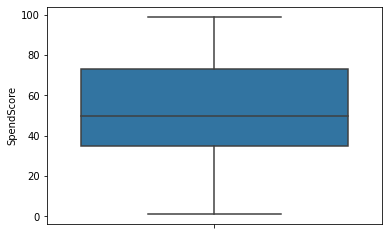

In [44]:
#Check outlier in numerical variable: 'SpendScore'
sns.boxplot(y="SpendScore",data=df_pd2)
plt.show()

From those bloxplot above, we can see outlier just in AnnIncome variable.

### Handle of outlier
Outlier is observations that fall below lower side or above upper side.

To handle outlier we approach by replacing the value greater than upper side with upper side value and also replacing the value lower than lower side with lower side value.
So, we need calculate upper and lower side from quantile value, quantile is probability distribution of variable. In General, there are three quantile:
1. Q1 = the value that cut off 25% of the first data when it is sorted in ascending order. 
2. Q2 = cut off data, or median, it's 50 % of the data 
3. Q3 = the value that cut off 75% of the first data when it is sorted in ascending order.

IQR or interquartile range is range between Q1 and Q3. IQR = Q3 - Q1.

Upper side = Q3 + 1.5 * IQR

Lower side = Q1 - 1.5 * IQR

In [45]:
#create quantile dataframe
def quantile(e):
    """Input is dataframe and return new dataframe with value of quantile from numerical columns"""
    percentiles = [0.25, 0.5, 0.75]
    quant=spark.createDataFrame(zip(percentiles, *e.approxQuantile(num_cols, percentiles, 0.0)),
                               ['percentile']+num_cols) #calculate quantile from pyspark dataframe, 0.0 is relativeError,
                                                        #The relative target precision to achieve (>= 0). If set to zero, 
                                                        #the exact quantiles are computed, which could be very expensive
                                                        #and aggregate the result with percentiles variable, 
                                                        #then create pyspark dataframe
    return quant

In [46]:
quantile=quantile(df)

In [47]:
def upper_value(b,c):
    """Input is quantile dataframe and name of numerical column and Retrun upper value from the column"""
    q1 = b.select(c).collect()[0][0] #select value of q1 from the column
    q2 = b.select(c).collect()[1][0] #select value of q2 from the column
    q3 = b.select(c).collect()[2][0] #select value of q3 from the column
    IQR=q3-q1  #calculate the value of IQR
    upper= q3 + (IQR*1.5)   #calculate the value of upper side
    return upper

In [48]:
help(upper_value)

Help on function upper_value in module __main__:

upper_value(b, c)
    Input is quantile dataframe and name of numerical column and Retrun upper value from the column



In [49]:
def lower_value(b,c):
    """Input is quantile dataframe and name of numerical column and Retrun lower value from the column"""
    q1 = b.select(c).collect()[0][0] #select value of q1 from the column
    q2 = b.select(c).collect()[1][0] #select value of q2 from the column
    q3 = b.select(c).collect()[2][0] #select value of q3 from the column
    IQR=q3-q1                   #calculate the value of IQR
    lower= q1 - (IQR*1.5)       #calculate the value of lower side
    return lower

In [50]:
help(lower_value)

Help on function lower_value in module __main__:

lower_value(b, c)
    Input is quantile dataframe and name of numerical column and Retrun lower value from the column



#### Replacing outlier

In [51]:
def replce_outlier_up2(d,col, value):
    """Input is name of numerical column and it's upper side value"""
    d=d.withColumn(col, F.when(d[col] > value , value).otherwise(d[col]))
    return d

In [52]:
def replce_outlier_low2(d,col, value):
    """Input is name of numerical column and it's lower side value"""
    d=d.withColumn(col, F.when(d[col] < value , value).otherwise(d[col]))
    return d

In [53]:
#call function to calculate lower side and replace value under lower side with value lower side
for i in num_cols:
    lower=lower_value(quantile,i)
    df=replce_outlier_low2(df, i, lower)

In [54]:
#call function to calculate upper side and replace value above upper side with value upper side
for x in num_cols:
    upper=upper_value(quantile,x)
    df=replce_outlier_up2(df, x, upper)

In [55]:
type(df)

pyspark.sql.dataframe.DataFrame

#### Check distribution after replacing outlier

In [56]:
df.select(num_cols).describe().show()

+-------+-----------------+------------------+------------------+
|summary|              Age|         AnnIncome|        SpendScore|
+-------+-----------------+------------------+------------------+
|  count|              200|               200|               200|
|   mean|            38.85|             60.54|              50.2|
| stddev|13.96900733155888|26.206915348058445|25.823521668370173|
|    min|             18.0|              15.0|               1.0|
|    max|             70.0|             135.0|              99.0|
+-------+-----------------+------------------+------------------+



In [57]:
df_pd3=df.toPandas()

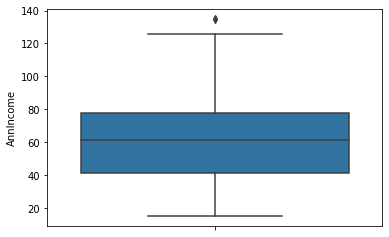

In [58]:
#Check outlier in numerical variable: 'AnnIncome'
sns.boxplot(y="AnnIncome",data=df_pd3)
plt.show()

### Feature Engineering
Before splitting the data train, all categorical variables must be made numerical. There are several approaches to categorical variables in SparkML, including:
1. StringIndexer, which is to encode the string label into the index label by sequencing the string frequency descending and giving the smallest index (0)
at most string frequency.
2. One-hot Encoding, which is mapping the label column (string label) on the binary column.
3. Vector assembler, which is mapping all columns in vector.

### Scenario I
In this scenario, we will include OneHotEncoder process.

In [59]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- AnnIncome: double (nullable = true)
 |-- SpendScore: double (nullable = true)



In [60]:
# define columns name for string indexer and one hot encoder processing
cat_columns_string_vec = []
for c in cat_cols:
    cat_columns_string= c+"_vec"
    cat_columns_string_vec.append(cat_columns_string)

cat_columns_string_vec

['Gender_vec']

In [61]:
#create index for categorical variables with stringIndexer   
stringIndexer = [StringIndexer(inputCol=x, outputCol=x+"_Index")
                  for x in cat_cols]
#use oneHotEncoder to convert categorical variable to binary
encoder = [OneHotEncoder(inputCol=x+"_Index", outputCol=y)
           for x,y in zip(cat_cols, cat_columns_string_vec)]
tmp = [[i,j] for i,j in zip(stringIndexer, encoder)]
tmp = [i for sublist in tmp for i in sublist]

In [62]:
#define columns for vector assembler processing
cols_assember=num_cols + cat_columns_string_vec
cols_assember

['Age', 'AnnIncome', 'SpendScore', 'Gender_vec']

In [63]:
#create vector assembler from cols_assember
assembler=VectorAssembler(inputCols=cols_assember, outputCol='features')
tmp += [assembler]

#create pipeline for stringIndexer, oneHotEncoder and vectorassembler
pipeline=Pipeline(stages=tmp)

In [64]:
#fit and transform pipeline to dataframe
df_final = pipeline.fit(df).transform(df)

In [65]:
df_final.show(4)

+---+------+----+---------+----------+------------+-------------+--------------------+
| Id|Gender| Age|AnnIncome|SpendScore|Gender_Index|   Gender_vec|            features|
+---+------+----+---------+----------+------------+-------------+--------------------+
|  1|  Male|19.0|     15.0|      39.0|         1.0|    (1,[],[])|[19.0,15.0,39.0,0.0]|
|  2|  Male|21.0|     15.0|      81.0|         1.0|    (1,[],[])|[21.0,15.0,81.0,0.0]|
|  3|Female|20.0|     16.0|       6.0|         0.0|(1,[0],[1.0])| [20.0,16.0,6.0,1.0]|
|  4|Female|23.0|     16.0|      77.0|         0.0|(1,[0],[1.0])|[23.0,16.0,77.0,1.0]|
+---+------+----+---------+----------+------------+-------------+--------------------+
only showing top 4 rows



In [66]:
#create model scaler for normalization
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [67]:
#Compute ScalerModel by fitting the StandardScaler
scalerModel = scaler.fit(df_final)

In [68]:
# Normalize each features to have unit standard deviation.
cluster_final_data = scalerModel.transform(df_final).select('Id', 'scaledFeatures')
cluster_final_data.show()

+---+--------------------+
| Id|      scaledFeatures|
+---+--------------------+
|  1|[1.36015391423519...|
|  2|[1.50332801047048...|
|  3|[1.43174096235284...|
|  4|[1.64650210670576...|
|  5|[2.21919849164690...|
|  6|[1.57491505858812...|
|  7|[2.50554668411747...|
|  8|[1.64650210670576...|
|  9|[4.58157107952909...|
| 10|[2.14761144352926...|
| 11|[4.79633222388201...|
| 12|[2.50554668411747...|
| 13|[4.15204879082323...|
| 14|[1.71808915482340...|
| 15|[2.64872078035275...|
| 16|[1.57491505858812...|
| 17|[2.50554668411747...|
| 18|[1.43174096235284...|
| 19|[3.72252650211738...|
| 20|[2.50554668411747...|
+---+--------------------+
only showing top 20 rows



### Modelling

#### Optimize choice of k

One disadvantage of KMeans is that the algortihm must told how many cluster - k- that should try to find. To optimize of k, we group fraction of the data for different k and look for an "elbow" in the cost function. Then, we plot the "elbow".

In [69]:
from pyspark.ml.evaluation import ClusteringEvaluator

In [70]:
#Compute cost function
cost= np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_final)

    predictions = model.transform(df_final)
    evaluator = ClusteringEvaluator()
    cost[k] = evaluator.evaluate(predictions)



In [71]:
cost

array([0.        , 0.        , 0.43440805, 0.45114607, 0.57346897,
       0.6284431 , 0.59808113, 0.62466439, 0.60626017, 0.59832178,
       0.55163094, 0.54950512, 0.54192747, 0.53097025, 0.53489851,
       0.51434307, 0.53929645, 0.47209833, 0.51447302, 0.48263949])

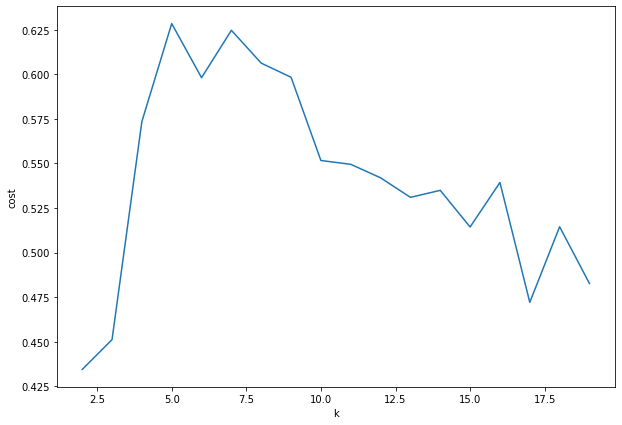

In [72]:
#Plot the cost
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(range(2,20), cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()

From pictures above, we can see that there is litte gain after k=5, so we stick at are values.

In [73]:
#Create model KMeans with K=5
#kmeans2 = KMeans(featuresCol='scaledFeatures',k=2).setSeed(1)

k = 5
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_final)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[24.96 28.04 77.    0.56]
[45.2173913  26.30434783 20.91304348  0.60869565]
[40.32432432 87.37837838 18.18918919  0.48648649]
[32.69230769 86.48717949 82.12820513  0.53846154]
[43.93421053 55.21052632 49.44736842  0.59210526]


In [74]:
#transfrom model to dataset
test=model.transform(df_final)

In [75]:
type(test)

pyspark.sql.dataframe.DataFrame

In [76]:
test.show(4)

+---+------+----+---------+----------+------------+-------------+--------------------+----------+
| Id|Gender| Age|AnnIncome|SpendScore|Gender_Index|   Gender_vec|            features|prediction|
+---+------+----+---------+----------+------------+-------------+--------------------+----------+
|  1|  Male|19.0|     15.0|      39.0|         1.0|    (1,[],[])|[19.0,15.0,39.0,0.0]|         1|
|  2|  Male|21.0|     15.0|      81.0|         1.0|    (1,[],[])|[21.0,15.0,81.0,0.0]|         0|
|  3|Female|20.0|     16.0|       6.0|         0.0|(1,[0],[1.0])| [20.0,16.0,6.0,1.0]|         1|
|  4|Female|23.0|     16.0|      77.0|         0.0|(1,[0],[1.0])|[23.0,16.0,77.0,1.0]|         0|
+---+------+----+---------+----------+------------+-------------+--------------------+----------+
only showing top 4 rows



In [77]:
num_cols

['Age', 'AnnIncome', 'SpendScore']

In [78]:
#Assign cluster to the event in data
prediction= model.transform(df_final).select(*num_cols,*cat_cols, 'prediction').collect()

#create dataframe 
prediction=spark.createDataFrame(prediction)

In [79]:
prediction.show()

+----+---------+----------+------+----------+
| Age|AnnIncome|SpendScore|Gender|prediction|
+----+---------+----------+------+----------+
|19.0|     15.0|      39.0|  Male|         1|
|21.0|     15.0|      81.0|  Male|         0|
|20.0|     16.0|       6.0|Female|         1|
|23.0|     16.0|      77.0|Female|         0|
|31.0|     17.0|      40.0|Female|         1|
|22.0|     17.0|      76.0|Female|         0|
|35.0|     18.0|       6.0|Female|         1|
|23.0|     18.0|      94.0|Female|         0|
|64.0|     19.0|       3.0|  Male|         1|
|30.0|     19.0|      72.0|Female|         0|
|67.0|     19.0|      14.0|  Male|         1|
|35.0|     19.0|      99.0|Female|         0|
|58.0|     20.0|      15.0|Female|         1|
|24.0|     20.0|      77.0|Female|         0|
|37.0|     20.0|      13.0|  Male|         1|
|22.0|     20.0|      79.0|  Male|         0|
|35.0|     21.0|      35.0|Female|         1|
|20.0|     21.0|      66.0|  Male|         0|
|52.0|     23.0|      29.0|  Male|

In [80]:
#grouping by our prediction of cluster
prediction.groupBy('prediction').count().sort(col('prediction')).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|   25|
|         1|   23|
|         2|   37|
|         3|   39|
|         4|   76|
+----------+-----+



### Scenario 2

We will exclude OneHotEncoder processing for categorical variable. We just select numerical variables as predictor

In [82]:
df_final2=df.drop(*cat_cols)
df_final2.show(4)

+---+----+---------+----------+
| Id| Age|AnnIncome|SpendScore|
+---+----+---------+----------+
|  1|19.0|     15.0|      39.0|
|  2|21.0|     15.0|      81.0|
|  3|20.0|     16.0|       6.0|
|  4|23.0|     16.0|      77.0|
+---+----+---------+----------+
only showing top 4 rows



In [83]:
#define columns for vector assembler processing
cols_assember=num_cols

In [84]:
#create vector assembler from cols_assember
assembler=VectorAssembler(inputCols=cols_assember, outputCol='features')

In [85]:
#transform vector assembler to dataset
final_data2 = assembler.transform(df_final2)

In [86]:
final_data2.show(4)

+---+----+---------+----------+----------------+
| Id| Age|AnnIncome|SpendScore|        features|
+---+----+---------+----------+----------------+
|  1|19.0|     15.0|      39.0|[19.0,15.0,39.0]|
|  2|21.0|     15.0|      81.0|[21.0,15.0,81.0]|
|  3|20.0|     16.0|       6.0| [20.0,16.0,6.0]|
|  4|23.0|     16.0|      77.0|[23.0,16.0,77.0]|
+---+----+---------+----------+----------------+
only showing top 4 rows



In [87]:
#create model scaler for normalization
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [88]:
# Compute ScalerModel by fitting the StandardScaler
scalerModel = scaler.fit(final_data2)

In [89]:
# Normalize each feature to have unit standard deviation.
cluster_final_data2 = scalerModel.transform(final_data2).select('Id', 'scaledFeatures')
cluster_final_data2.show(6)

+---+--------------------+
| Id|      scaledFeatures|
+---+--------------------+
|  1|[1.36015391423519...|
|  2|[1.50332801047048...|
|  3|[1.43174096235284...|
|  4|[1.64650210670576...|
|  5|[2.21919849164690...|
|  6|[1.57491505858812...|
+---+--------------------+
only showing top 6 rows



#### Optimize choice of k

In [90]:
#Compute cost function
cost2= np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")

    model2 = kmeans.fit(final_data2)
    
   
    predictions = model2.transform(final_data2)
    evaluator = ClusteringEvaluator()

    cost2[k] = evaluator.evaluate(predictions)

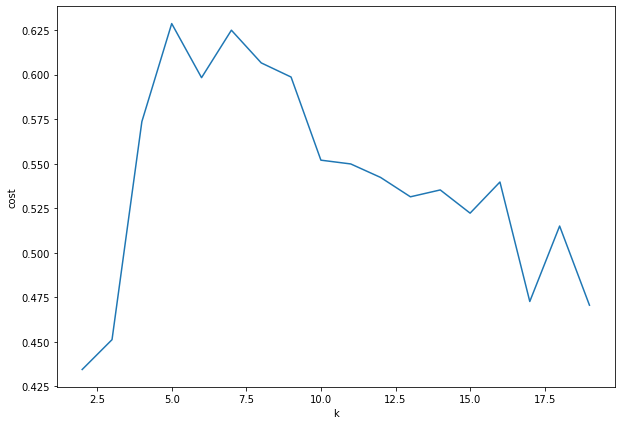

In [91]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(range(2,20), cost2[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()

From picture above, we can see that there is litte gain after k=5, so we can stick at that value.

In [92]:
#Create model KMeans
k = 5
kmeans2 = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model_k5 = kmeans2.fit(final_data2)
centers2 = model_k5.clusterCenters()

print("Cluster Centers: ")
for center in centers2:
    print(center)

Cluster Centers: 
[24.96 28.04 77.  ]
[45.2173913  26.30434783 20.91304348]
[40.32432432 87.37837838 18.18918919]
[32.69230769 86.48717949 82.12820513]
[43.93421053 55.21052632 49.44736842]


In [93]:
#Assign cluster to the event in data
prediction2= model_k5.transform(final_data2).select(*num_id,*num_cols, 'prediction').collect()

#create dataframe 
prediction2=spark.createDataFrame(prediction2)

In [94]:
#show dataframe
prediction2.show()

+---+----+---------+----------+----------+
| Id| Age|AnnIncome|SpendScore|prediction|
+---+----+---------+----------+----------+
|  1|19.0|     15.0|      39.0|         1|
|  2|21.0|     15.0|      81.0|         0|
|  3|20.0|     16.0|       6.0|         1|
|  4|23.0|     16.0|      77.0|         0|
|  5|31.0|     17.0|      40.0|         1|
|  6|22.0|     17.0|      76.0|         0|
|  7|35.0|     18.0|       6.0|         1|
|  8|23.0|     18.0|      94.0|         0|
|  9|64.0|     19.0|       3.0|         1|
| 10|30.0|     19.0|      72.0|         0|
| 11|67.0|     19.0|      14.0|         1|
| 12|35.0|     19.0|      99.0|         0|
| 13|58.0|     20.0|      15.0|         1|
| 14|24.0|     20.0|      77.0|         0|
| 15|37.0|     20.0|      13.0|         1|
| 16|22.0|     20.0|      79.0|         0|
| 17|35.0|     21.0|      35.0|         1|
| 18|20.0|     21.0|      66.0|         0|
| 19|52.0|     23.0|      29.0|         1|
| 20|35.0|     23.0|      98.0|         0|
+---+----+-

In [95]:
#grouping by cluster prediction
prediction2.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|   25|
|         1|   23|
|         4|   76|
|         3|   39|
|         2|   37|
+----------+-----+



Join prediction with original data

In [96]:
#Join 
prediction3=prediction2.join(df, 'Id')
prediction3.show(6)

+---+----+---------+----------+----------+------+----+---------+----------+
| Id| Age|AnnIncome|SpendScore|prediction|Gender| Age|AnnIncome|SpendScore|
+---+----+---------+----------+----------+------+----+---------+----------+
|  1|19.0|     15.0|      39.0|         1|  Male|19.0|     15.0|      39.0|
|  2|21.0|     15.0|      81.0|         0|  Male|21.0|     15.0|      81.0|
|  3|20.0|     16.0|       6.0|         1|Female|20.0|     16.0|       6.0|
|  4|23.0|     16.0|      77.0|         0|Female|23.0|     16.0|      77.0|
|  5|31.0|     17.0|      40.0|         1|Female|31.0|     17.0|      40.0|
|  6|22.0|     17.0|      76.0|         0|Female|22.0|     17.0|      76.0|
+---+----+---------+----------+----------+------+----+---------+----------+
only showing top 6 rows



In [97]:
#grouping by cluster prediction and check average of age
prediction2.groupBy('prediction').agg({'Age':'mean'}).show()

+----------+-----------------+
|prediction|         avg(Age)|
+----------+-----------------+
|         0|            24.96|
|         1|45.21739130434783|
|         4|43.93421052631579|
|         3|32.69230769230769|
|         2|40.32432432432432|
+----------+-----------------+



In [98]:
#grouping by cluster prediction and check average of all numerical variable
prediction2.groupBy('prediction').avg().show()

+----------+------------------+-----------------+------------------+-----------------+---------------+
|prediction|           avg(Id)|         avg(Age)|    avg(AnnIncome)|  avg(SpendScore)|avg(prediction)|
+----------+------------------+-----------------+------------------+-----------------+---------------+
|         0|             27.48|            24.96|             28.04|             77.0|            0.0|
|         1|              23.0|45.21739130434783|26.304347826086957|20.91304347826087|            1.0|
|         4| 86.01315789473684|43.93421052631579| 55.21052631578947|49.44736842105263|            4.0|
|         3|             162.0|32.69230769230769| 86.48717948717949|82.12820512820512|            3.0|
|         2|162.94594594594594|40.32432432432432| 87.37837837837837|18.18918918918919|            2.0|
+----------+------------------+-----------------+------------------+-----------------+---------------+



#### Visualize the result

To create the visualization, convert the result dataframe spark to pandas dataframe. We will create 3D visualization from Age, AnnIncome and SpendScore as predictor.

In [103]:
#convert prediction to Pandas
pred_pd=prediction2.toPandas().set_index('Id')

In [104]:
#show pandas dataframe
pred_pd.head(5)

,Age,AnnIncome,SpendScore,prediction
Id,,,,
1,19.0,15.0,39.0,1
2,21.0,15.0,81.0,0
3,20.0,16.0,6.0,1
4,23.0,16.0,77.0,0
5,31.0,17.0,40.0,1


In [105]:
from mpl_toolkits.mplot3d import Axes3D

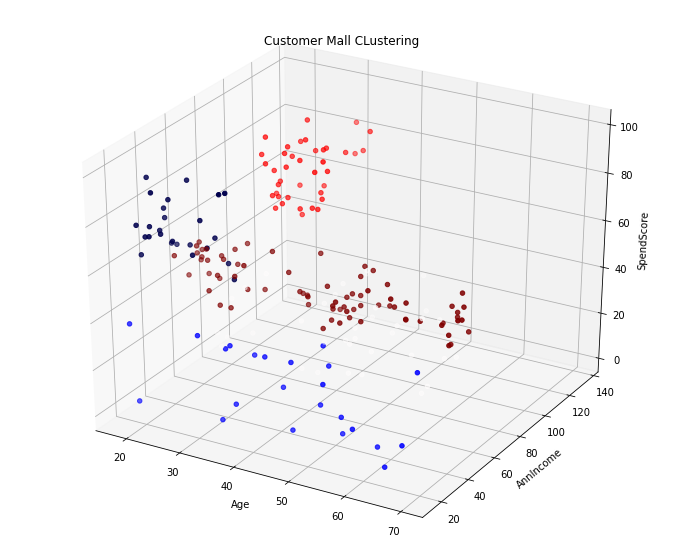

In [106]:
#Create 3d visualization
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pred_pd.Age, pred_pd.AnnIncome, pred_pd.SpendScore, c=pred_pd.prediction, cmap="seismic")
threedee.set_title('Customer Mall CLustering')
threedee.set_xlabel('Age')
threedee.set_ylabel('AnnIncome')
threedee.set_zlabel('SpendScore')
plt.show()